In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torchvision
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time

Based on: https://nextjournal.com/gkoehler/pytorch-mnist

### Set hyperparameters

Setting hyperparameters for training

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

### Configure data loaders

In [3]:
data_dir = 'data/'

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(data_dir, train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(data_dir, train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                                 ])),
  batch_size=batch_size_test, shuffle=True)
    
type(test_loader)

torch.utils.data.dataloader.DataLoader

Figuring out what the code is doing. Check what is inside test_loader

In [4]:
#testloader is an iterable object. Lets get the iterator
test1 = iter(test_loader)
print(type(test1))

#use next to get the value which is a list of lenght 2 [val0, val1]
val1 = next(test1)
print(type(val1))
print("lenght:", len(val1))

#List value 0 is a 1000 * 1 * 28 * 28 Tensor. The images
print(type(val1[0]))
print("Shape: ", val1[0].shape)

#List value 1 is a 1000 Tensor. The labels
print(type(val1[1]))
print("Shape: ", val1[1].shape)

#we can use two values when returning function, it works the same
val1, val2 = next(test1)
#images
print("Shape: ", val1.shape)
#labels
print("Shape: ", val2.shape)


<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
<class 'list'>
lenght: 2
<class 'torch.Tensor'>
Shape:  torch.Size([1000, 1, 28, 28])
<class 'torch.Tensor'>
Shape:  torch.Size([1000])
Shape:  torch.Size([1000, 1, 28, 28])
Shape:  torch.Size([1000])


### Check how train_loader handles batch size

In [5]:
#testloader is an iterable object. Lets get the iterator
test1 = iter(train_loader)
print(type(test1))

#use next to get the value which is a list of lenght 2 [val0, val1]
val1, val2 = next(test1)

#When doing a next() in train_loader it returns 64 elements which is the batch size
print("Shape: ", val1.shape)
#We get also 64 corresponding labels
print("Shape: ", val2.shape)

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
Shape:  torch.Size([64, 1, 28, 28])
Shape:  torch.Size([64])


Either test_loader and train_loaders are DataLoader classes. This class is iterable.

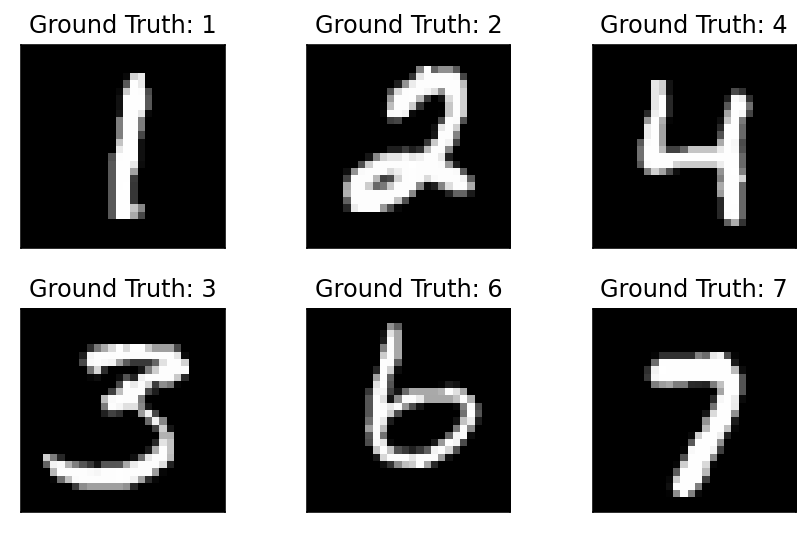

In [6]:
#enumerate functions adds an index to the iterable objetct
#using enumerate helps to add an index when using for, for example
examples = enumerate(test_loader)

#unpacking with parentesis because first return value is the index, second is a two values list. Check code below
#li = [[1,2], [2,3]]
#bla = enumerate(li)
#idx, (x, y) = next(bla)
##idx = 0, x = 1, y = 2

batch_idx, (example_data, example_targets) = next(examples)


#Print 6 images with their respective value
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [8]:
#Network model
network = Net()

#Stochastic gradient decent
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [9]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [10]:
def train(epoch):
  #
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    
    #set parameters gradients to 0
    optimizer.zero_grad()
    
    #runs model with data and returns result in output
    #here data contains a 64 * 1 * 28 * 28 tensor, 64 is batch size
    output = network(data)
    
    #Use negative log likelihood loss.
    loss = F.nll_loss(output, target)
    
    #with this gradients are calculated
    loss.backward()
    
    #update gradients
    optimizer.step()
    
    #Display iteration statistics
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'results/model.pth')
      torch.save(optimizer.state_dict(), 'results/optimizer.pth')

In [11]:
def test():
  #Sets the module in evaluation mode
  network.eval()
  test_loss = 0
  correct = 0
    
  #dont update dynamic computation graph
  with torch.no_grad():
    #for every example in test
    for data, target in test_loader:
      #evaluate the model
      output = network(data)
      #acumulate the loss
      test_loss += F.nll_loss(output, target, size_average=False).item()
      
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [12]:
#test
#n_epochs = 1
#Check accuaracy before training
test()
tic = time.perf_counter()

for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
    
toc = time.perf_counter()

print(f"Time elapsed: {toc - tic:0.4f} seconds")

C:\Users\Erick\miniconda3\envs\pytorch_examples\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Erick\miniconda3\envs\pytorch_examples\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3190, Accuracy: 897/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.320578
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.319637
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.257308
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.275689
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.281048
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.290095
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.243121
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.237102
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.239702
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.205247
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.188919
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.104611
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.083791
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.886865
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.831496
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.683767
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.606192
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.437653
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.522481
Train Epoch: 1 [12160/6

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.377071
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.325429
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.334784
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.326240
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.610357
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.440820
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.276976
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.358243
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.239352
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.272987
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.254651
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.424951
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.137748
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.204382
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.264065
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.217264
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.543850
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.196828
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.268628
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.382312


Text(0, 0.5, 'negative log likelihood loss')

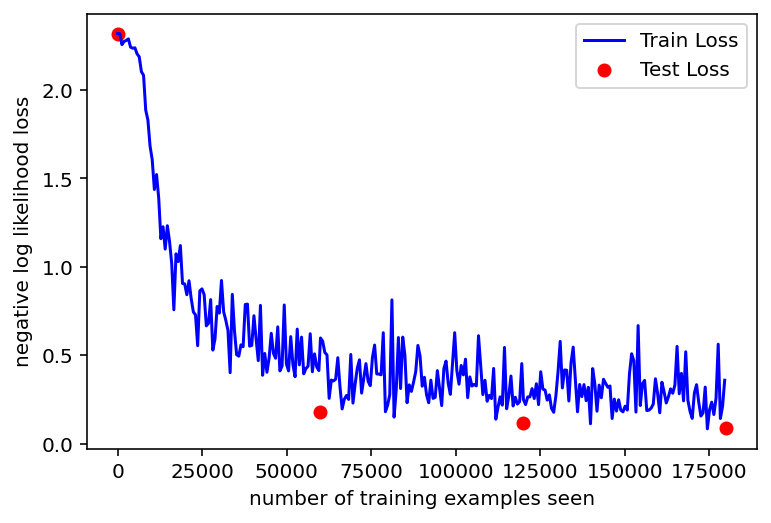

In [13]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
#fig

In [65]:
with torch.no_grad():
  output = network(example_data)

C:\Users\Erick\miniconda3\envs\pytorch_examples\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


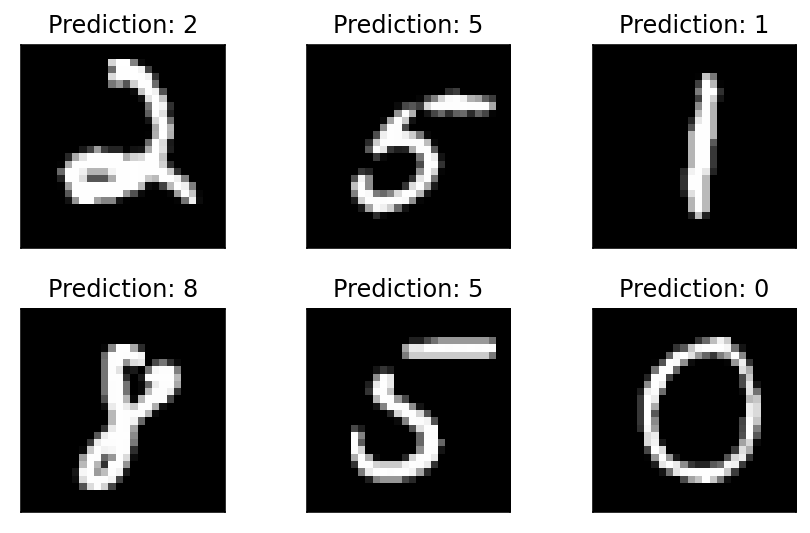

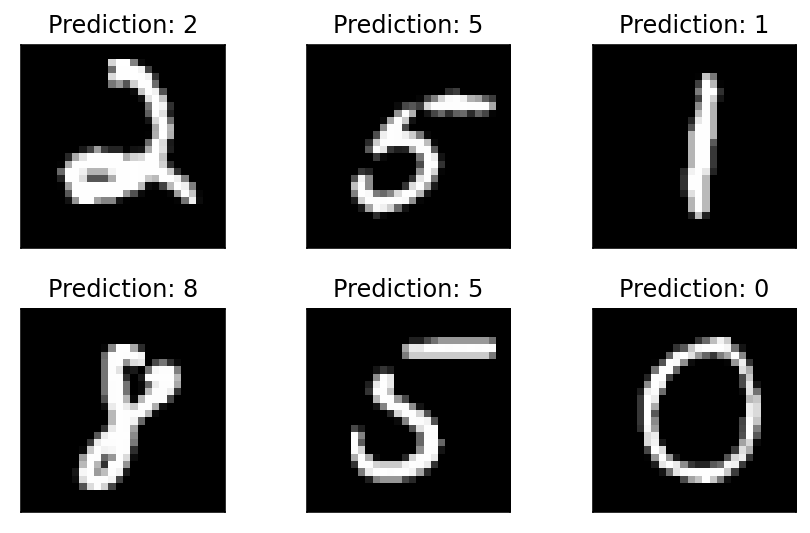

In [66]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

### Train with GPU (this is not working yet)

Enable cuda and train model to check time differences

In [29]:
#check if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

network_gpu = Net()
network_gpu.to(device)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [31]:

def train_gpu(epoch):
  #
  network_gpu.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    #send training data to GPU
    data = data.to(device)
    target = target.to(device)
    
    #set gradients to 0
    optimizer.zero_grad()
    #runs model with data and returns result in output
    output = network_gpu(data)
    
    #here is where the magic happens
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    
    #Display iteration statistics
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network_gpu.state_dict(), 'results/model.pth')
      torch.save(optimizer.state_dict(), 'results/optimizer.pth')

In [34]:
def test_gpu():
  #Sets the module in evaluation mode
  network_gpu.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)  
      output = network_gpu(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

### Train model with gpu (this is not working yet)

In [35]:

#Check accuaracy before training
test()
tic = time.perf_counter()

for epoch in range(1, n_epochs + 1):
  train_gpu(epoch)
  test_gpu()
    
toc = time.perf_counter()

print(f"Time elapsed: {toc - tic:0.4f} seconds")

C:\Users\Erick\miniconda3\envs\pytorch_examples\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 0.0949, Accuracy: 9690/10000 (97%)



RuntimeError: cuda runtime error (209) : no kernel image is available for execution on the device at C:/cb/pytorch_1000000000000/work/aten/src\THC/generic/THCTensorMath.cu:19